### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/gdrive')
#%cd /gdrive/My Drive/

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/ANN-challenge1
#%cd /content/drive/My Drive/
#%cd /gdrive/My Drive/ToySubmission

/content/drive/My Drive/Colab Notebooks/ANN-challenge1


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

### Load and process the dataset


> For the final model we did't use the following "Balance Classes" subsection



####Load Data - Basic Preprocessing

> Here we normalize pixels[0,1], we remove outliers (shrek & trololollo) and duplicates.


> Results: [4850,96,96,3] images. Healthy: 3060, Unhealthy: 1790






In [ ]:
# Conditional check for unzipping
unzip = False

# Unzip the 'animals.zip' file if the 'unzip' flag is True
if unzip:
    !unzip public_data.zip

In [ ]:
data = np.load('public_data.npz', allow_pickle=True)
print(data.files)

['data', 'labels']


In [ ]:
data_img = data['data']
labels = data['labels']

images = []
# images preprocessing
for img in data_img:
    img = (img / 255).astype(np.float32)  # image normalization

    # Make the image dataset squared
    dim = min(img.shape[:-1])
    img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

    if img is not None:
      images.append(img)

images = np.array(images)
print(images.shape)
print(labels.shape)


(5200, 96, 96, 3)
(5200,)


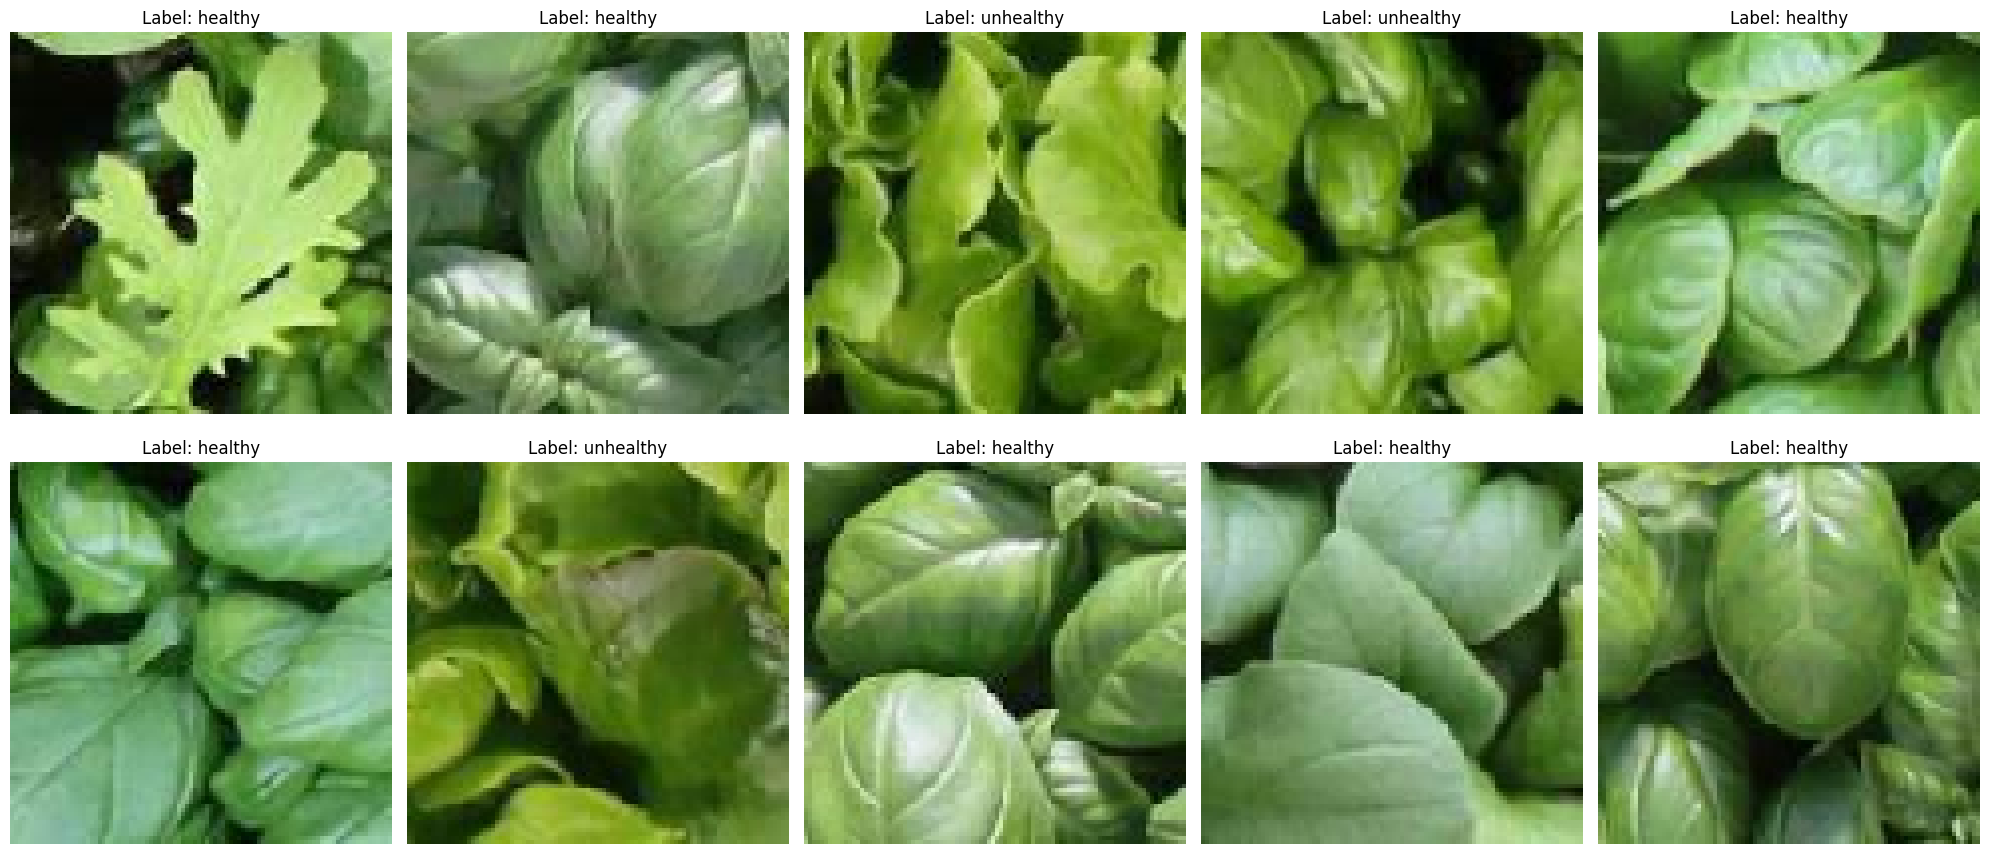

In [ ]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i % 2, i % num_img // 2]
    ax.imshow(np.clip(images[i], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f"Label: {labels[i]}", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
#identify outlier (shrek,trolollo)
outlier1, outlier2 = images[58], images[338]
outlier_idx = []
for i, image in enumerate(images):
  if np.array_equal(image, outlier1) or np.array_equal(image, outlier2):
    outlier_idx.append(i)
print(f'Number of outliers: {len(outlier_idx)}')

Number of outliers: 196


In [ ]:
#remove outliers
images = np.delete(images, outlier_idx, axis=0)
labels = np.delete(labels, outlier_idx, axis=0)

In [ ]:
print(images.shape)
print(labels.shape)

(5004, 96, 96, 3)
(5004,)


In [ ]:
#identify and remove duplicates
images, indices = np.unique(images, return_index=True, axis=0)
labels = labels[indices]
print(images.shape)
print(labels.shape)

(4850, 96, 96, 3)
(4850,)


In [ ]:
# Create dictionary to map labels
label_mapping = {"healthy": 0, "unhealthy": 1}

labels_numeric = np.array([label_mapping[label] for label in labels])
labels_numeric.shape

(4850,)

In [ ]:
# classes counter
count_zeros = len(labels_numeric) - np.count_nonzero(labels_numeric)
count_ones = np.count_nonzero(labels_numeric)

print("Number of healthy images [0]:", count_zeros)
print("Number of unhealthy images[1]:", count_ones)

Number of healthy images [0]: 3060
Number of unhealthy images[1]: 1790


In [ ]:
images.shape

(4850, 96, 96, 3)

####Visualization

In [ ]:
###see the other notebook

####Balance Classes

> Downsampling with Cosine Similarity Matrix





In [ ]:
###input: images, labels_numeric
healthy_idx = np.where(labels_numeric == 0)[0]
unhealthy_idx = np.where(labels_numeric == 1)[0]
print(len(healthy_idx))
print(len(unhealthy_idx))


healthy_images = images[healthy_idx]
unhealthy_images = images[unhealthy_idx]

# build cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity_matrix_healthy = cosine_similarity(healthy_images.reshape(healthy_images.shape[0], -1), healthy_images.reshape(healthy_images.shape[0], -1))
cosine_similarity_matrix_unhealthy = cosine_similarity(unhealthy_images.reshape(unhealthy_images.shape[0], -1), unhealthy_images.reshape(unhealthy_images.shape[0], -1))

print(cosine_similarity_matrix_healthy.shape)
print(cosine_similarity_matrix_unhealthy.shape)

3060
1790
(3060, 3060)
(1790, 1790)


In [ ]:
# remove duplicates according to cosine similarity
similar_healthy = []
similar_unhealthy = []

for i in range(cosine_similarity_matrix_healthy.shape[0]):
  for j in range(cosine_similarity_matrix_healthy.shape[1]):
    if cosine_similarity_matrix_healthy[i, j] > 0.93 and i != j:
      similar_healthy.append((i, j))

for i in range(cosine_similarity_matrix_unhealthy.shape[0]):
  for j in range(cosine_similarity_matrix_unhealthy.shape[1]):
    if cosine_similarity_matrix_unhealthy[i, j] > 0.93 and i != j:
      similar_unhealthy.append((i, j))

In [ ]:
# remove duplicate tuples (i,j) and (j,i) from similar
similar_healthy = list(set([tuple(sorted(t)) for t in similar_healthy]))
similar_unhealthy = list(set([tuple(sorted(t)) for t in similar_unhealthy]))

print(len(similar_healthy))
print(len(similar_unhealthy))

312
68


In [ ]:
# remove similar images such that only one image remains from each pair

healthy_idx_similar = np.unique([t[1] for t in similar_healthy])
unhealthy_idx_similar = np.unique([t[1] for t in similar_unhealthy])

print(len(healthy_idx_similar))
print(len(unhealthy_idx_similar))

98
27


In [ ]:
healthy_idx = np.delete(healthy_idx, healthy_idx_similar, axis=0)
unhealthy_idx = np.delete(unhealthy_idx, unhealthy_idx_similar, axis=0)

In [ ]:
# make both classes equally sized
healthy_idx = healthy_idx[:len(unhealthy_idx)]
len(healthy_idx), len(unhealthy_idx)

(2962, 1763)

In [ ]:
healthy_images = images[healthy_idx]
unhealthy_images = images[unhealthy_idx]
len(healthy_images), len(unhealthy_images)

(2962, 1763)

In [ ]:
images = np.concatenate((healthy_images, unhealthy_images), axis=0)
labels_numeric = np.concatenate((np.zeros(len(healthy_images)), np.ones(len(unhealthy_images))), axis=0)
print(images.shape)
print(labels_numeric.shape)

(4725, 96, 96, 3)
(4725,)


In [ ]:
# if the dataset is unbalanced, use class weights to balance the dataset
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(labels_numeric),
                                        y = labels_numeric)

class_weights = dict(enumerate(class_weights))

class_weights

{0: 0.7976029709655638, 1: 1.3400453771979581}

####Train, Validation, Test

In [ ]:
X = images
y = tfk.utils.to_categorical(labels_numeric,len(np.unique(labels_numeric)))
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=500, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=500, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4348, 96, 96, 3), y_train shape: (4348, 2)
X_val shape: (500, 96, 96, 3), y_val shape: (500, 2)
X_test shape: (2, 96, 96, 3), y_test shape: (2, 2)


In [ ]:
# count "healthy" e "unhealthy" in train,validation,test set
train_healthy_count = np.sum(y_train[:, 0])  # first column: "healthy"
train_unhealthy_count = np.sum(y_train[:, 1])  # second column: "unhealthy"

val_healthy_count = np.sum(y_val[:, 0])
val_unhealthy_count = np.sum(y_val[:, 1])

test_healthy_count = np.sum(y_test[:, 0])
test_unhealthy_count = np.sum(y_test[:, 1])

print("Training Set - Healthy:", train_healthy_count, "Unhealthy:", train_unhealthy_count)
print("Validation Set - Healthy:", val_healthy_count, "Unhealthy:", val_unhealthy_count)
print("Test Set - Healthy:", test_healthy_count, "Unhealthy:", test_unhealthy_count)



####Augmentations

In [ ]:
!pip install keras_cv

In [ ]:
import keras_cv
transformation = tf.keras.Sequential([
    keras_cv.layers.RandomSharpness(0.3, [0, 255]),
    keras_cv.layers.RandomShear(0.3, 0.3),
    keras_cv.layers.RandomCutout(0.4, 0.4),
    keras_cv.layers.AutoContrast([0, 255]),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.25),
], name="transformation")

In [ ]:
#transformation = tf.keras.Sequential([
#  tfkl.RandomFlip("horizontal"),
#  tfkl.RandomFlip("vertical"),
#  tfkl.RandomRotation(0.2),
#  tfkl.RandomZoom(0.2),
#])

### Models:

#### Basic Model ->no DataAug



In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 1000

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

In [ ]:
#for the basic models
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='auto'),
]

In [ ]:
def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0       

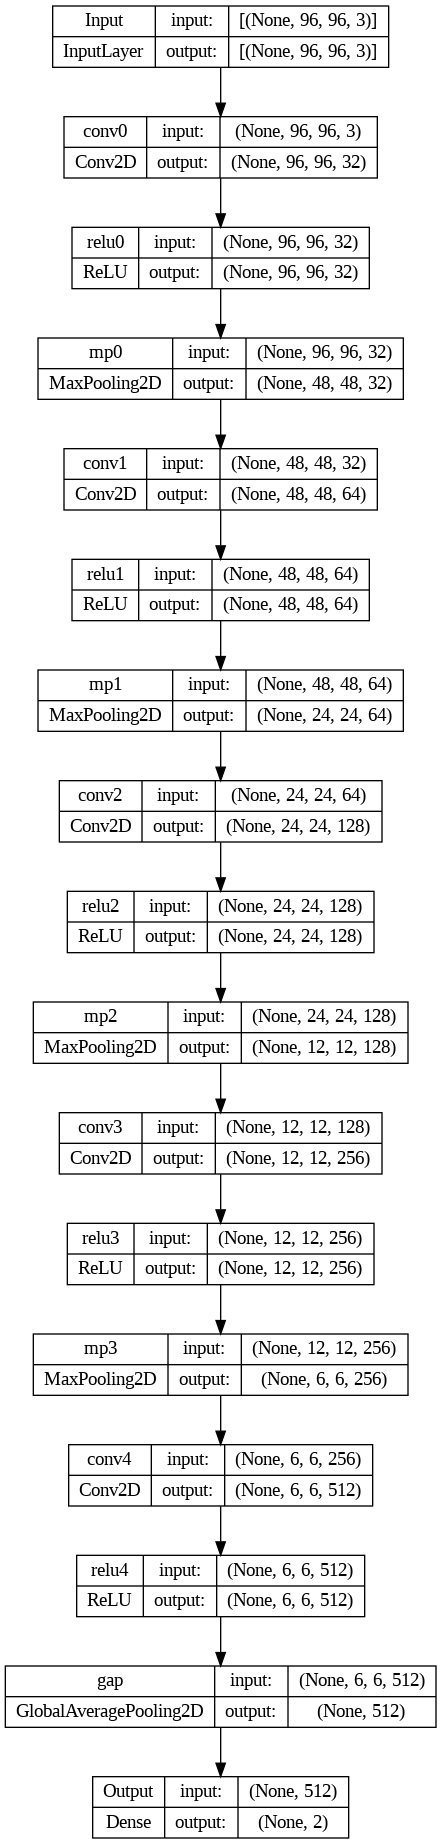

In [ ]:
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/1000
62/62 [==============================] - 13s 40ms/step - loss: 0.6587 - accuracy: 0.6280 - val_loss: 0.6617 - val_accuracy: 0.6275
Epoch 2/1000
62/62 [==============================] - 2s 26ms/step - loss: 0.6484 - accuracy: 0.6382 - val_loss: 0.6305 - val_accuracy: 0.6800
Epoch 3/1000
62/62 [==============================] - 2s 26ms/step - loss: 0.6313 - accuracy: 0.6522 - val_loss: 0.6480 - val_accuracy: 0.6325
Epoch 4/1000
62/62 [==============================] - 2s 27ms/step - loss: 0.6263 - accuracy: 0.6624 - val_loss: 0.5843 - val_accuracy: 0.7100
Epoch 5/1000
62/62 [==============================] - 2s 27ms/step - loss: 0.5820 - accuracy: 0.7065 - val_loss: 0.5948 - val_accuracy: 0.6850
Epoch 6/1000
62/62 [==============================] - 2s 30ms/step - loss: 0.5615 - accuracy: 0.7269 - val_loss: 0.5598 - val_accuracy: 0.7300
Epoch 7/1000
62/62 [==============================] - 2s 29ms/step - loss: 0.5497 - accuracy: 0.7302 - val_loss: 0.5606 - val_accuracy: 0.732

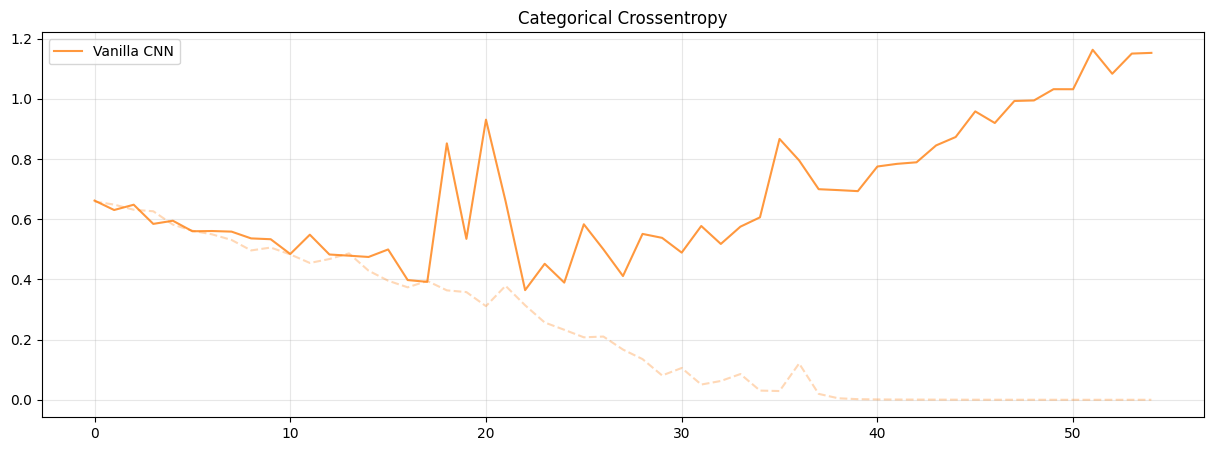

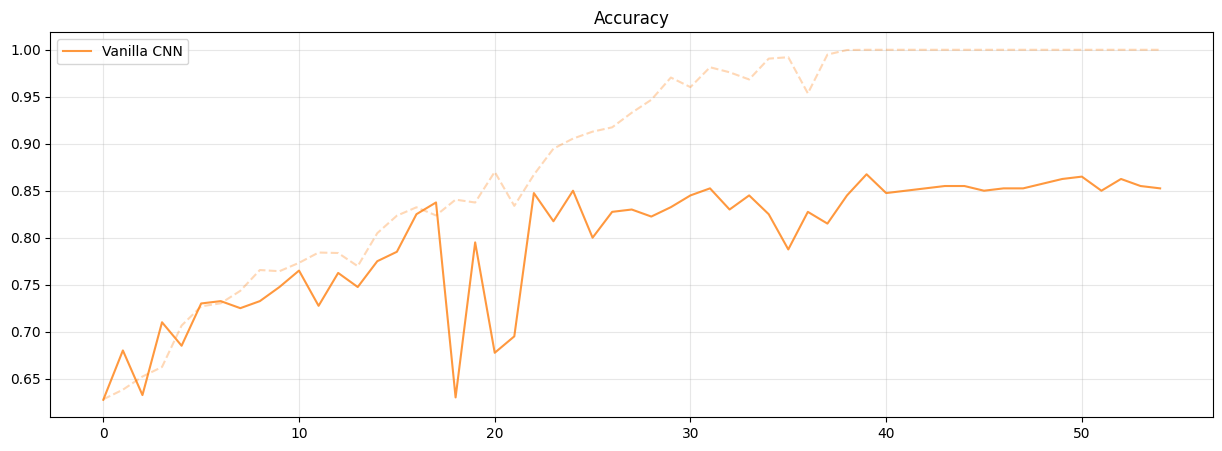

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the  model
model.save('BasicModel-noDataAug')

####Basic Model -> DataAug

In [ ]:
def build_model_with_augmentation(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    preprocessing = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        tfkl.RandomTranslation(0.2,0.2),
    ], name='preprocessing')

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(preprocessing)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0       

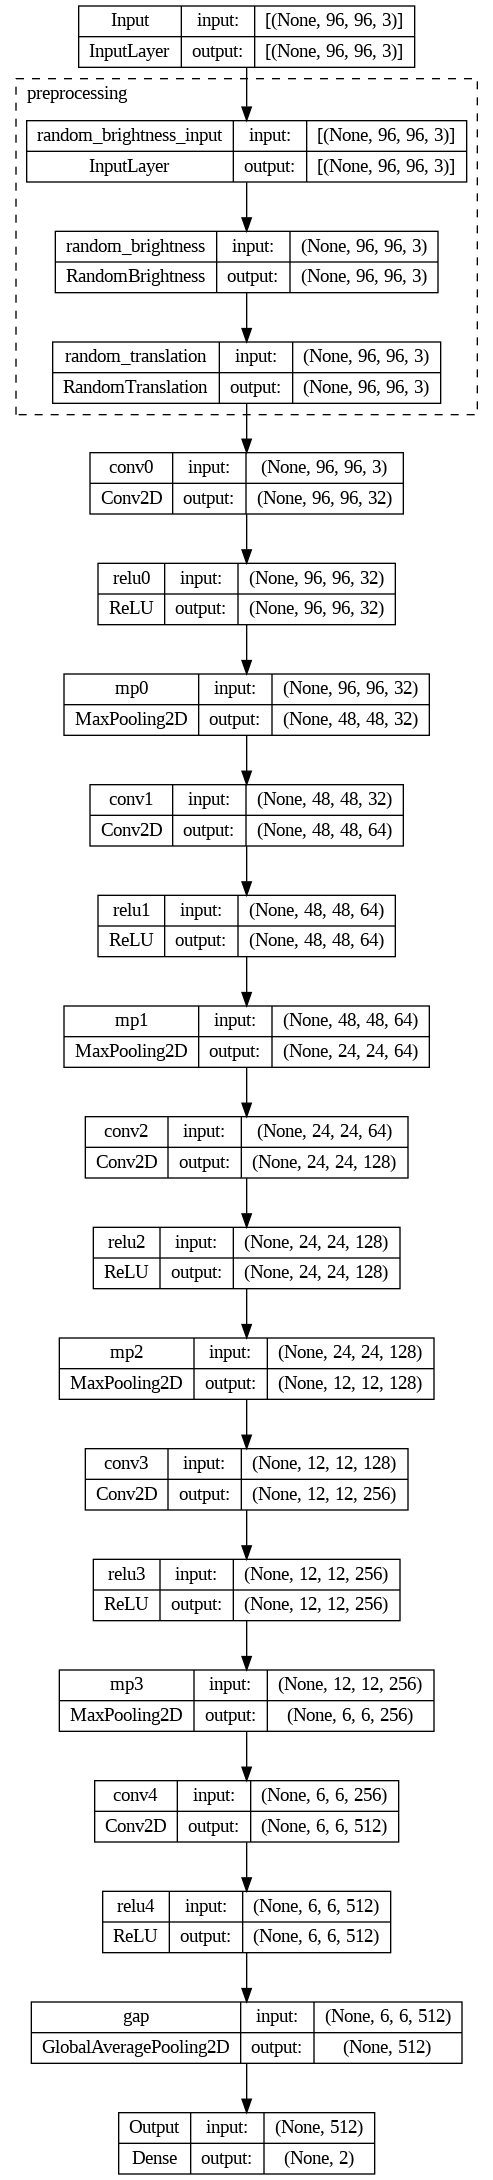

In [ ]:
augmented_model = build_model_with_augmentation()
augmented_model.summary()
tfk.utils.plot_model(augmented_model, expand_nested=True, show_shapes=True)

In [ ]:
#visualkeras.layered_view(augmented_model, legend=True) # selected font

In [ ]:
# Train the model
aug_history = augmented_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/1000
62/62 [==============================] - 5s 34ms/step - loss: 0.6705 - accuracy: 0.6268 - val_loss: 0.6610 - val_accuracy: 0.6275
Epoch 2/1000
62/62 [==============================] - 2s 29ms/step - loss: 0.6623 - accuracy: 0.6268 - val_loss: 0.6589 - val_accuracy: 0.6275
Epoch 3/1000
62/62 [==============================] - 2s 30ms/step - loss: 0.6615 - accuracy: 0.6250 - val_loss: 0.6615 - val_accuracy: 0.6275
Epoch 4/1000
62/62 [==============================] - 2s 30ms/step - loss: 0.6561 - accuracy: 0.6311 - val_loss: 0.6510 - val_accuracy: 0.6275
Epoch 5/1000
62/62 [==============================] - 2s 31ms/step - loss: 0.6600 - accuracy: 0.6288 - val_loss: 0.6602 - val_accuracy: 0.6275
Epoch 6/1000
62/62 [==============================] - 2s 28ms/step - loss: 0.6614 - accuracy: 0.6268 - val_loss: 0.6602 - val_accuracy: 0.6275
Epoch 7/1000
62/62 [==============================] - 2s 28ms/step - loss: 0.6606 - accuracy: 0.6280 - val_loss: 0.6563 - val_accuracy: 0.6300

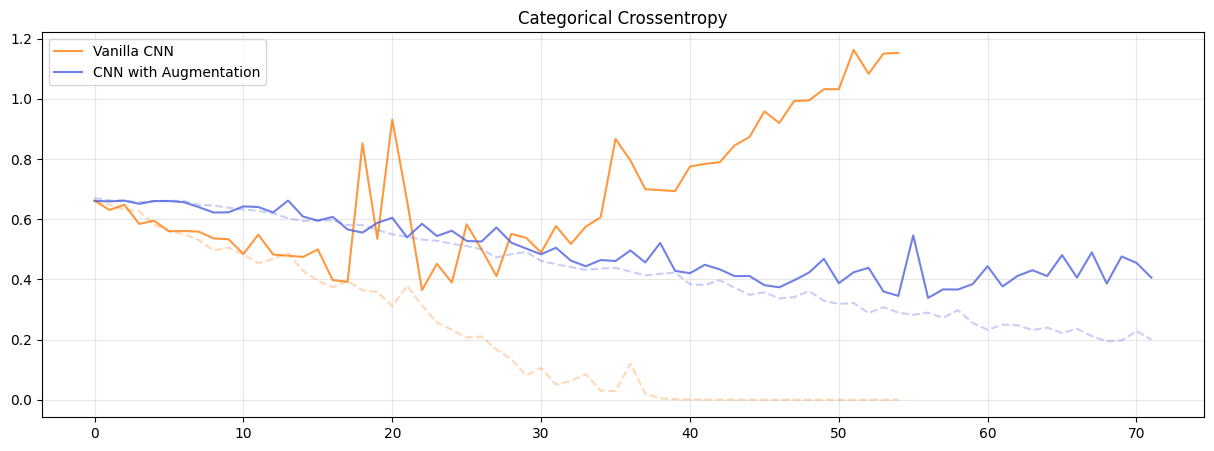

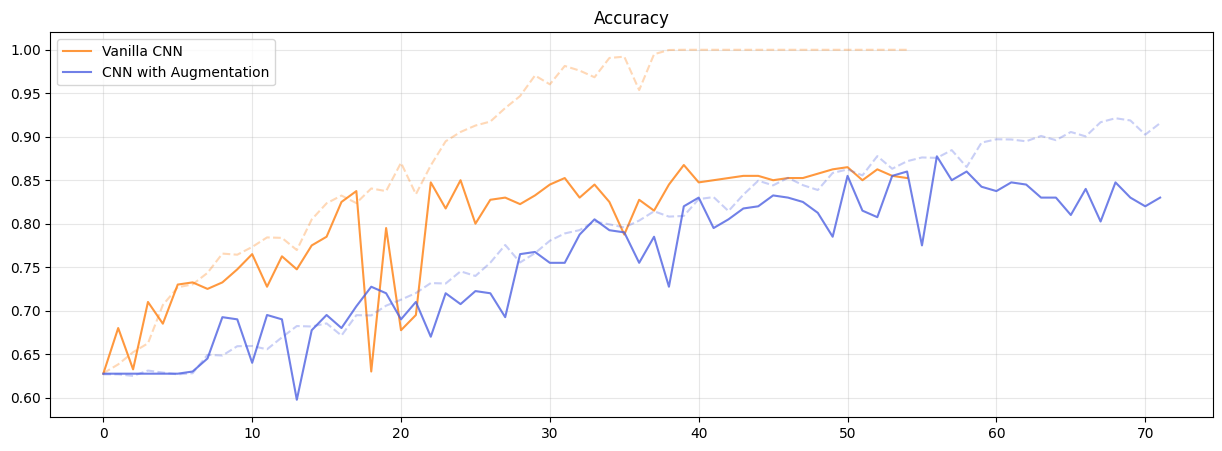

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.plot(aug_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(aug_history['val_loss'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.plot(aug_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(aug_history['val_accuracy'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
augmented_model.save('v2-clean-DataAugModel')

####MobileNetV2-Transfer Learning

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_input_MobileNetV2

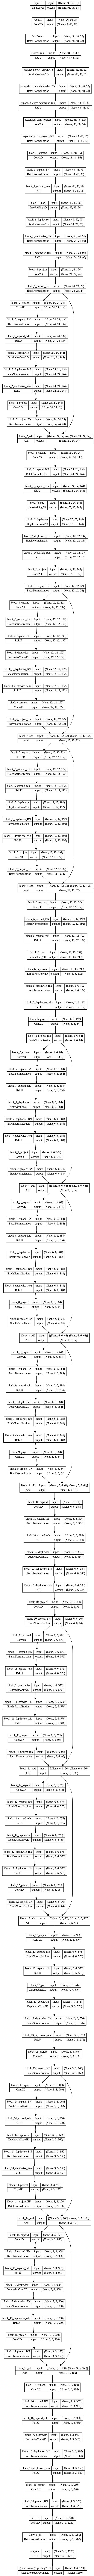

In [ ]:
#already imported library at beginnning of the file
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input_MobileNetV2(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (preprocess_input_MobileNetV2(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)],
    class_weight = class_weights
).history

Epoch 1/200
62/62 [==============================] - 7s 44ms/step - loss: 0.6257 - accuracy: 0.6591 - val_loss: 0.4972 - val_accuracy: 0.7750
Epoch 2/200
62/62 [==============================] - 2s 32ms/step - loss: 0.4757 - accuracy: 0.7735 - val_loss: 0.5118 - val_accuracy: 0.7700
Epoch 3/200
62/62 [==============================] - 2s 33ms/step - loss: 0.4373 - accuracy: 0.7931 - val_loss: 0.4768 - val_accuracy: 0.7900
Epoch 4/200
62/62 [==============================] - 2s 32ms/step - loss: 0.4051 - accuracy: 0.8161 - val_loss: 0.4641 - val_accuracy: 0.7950
Epoch 5/200
62/62 [==============================] - 2s 25ms/step - loss: 0.3905 - accuracy: 0.8278 - val_loss: 0.4617 - val_accuracy: 0.7875
Epoch 6/200
62/62 [==============================] - 2s 25ms/step - loss: 0.3758 - accuracy: 0.8334 - val_loss: 0.4469 - val_accuracy: 0.7900
Epoch 7/200
62/62 [==============================] - 2s 25ms/step - loss: 0.3587 - accuracy: 0.8408 - val_loss: 0.4900 - val_accuracy: 0.7625
Epoch 

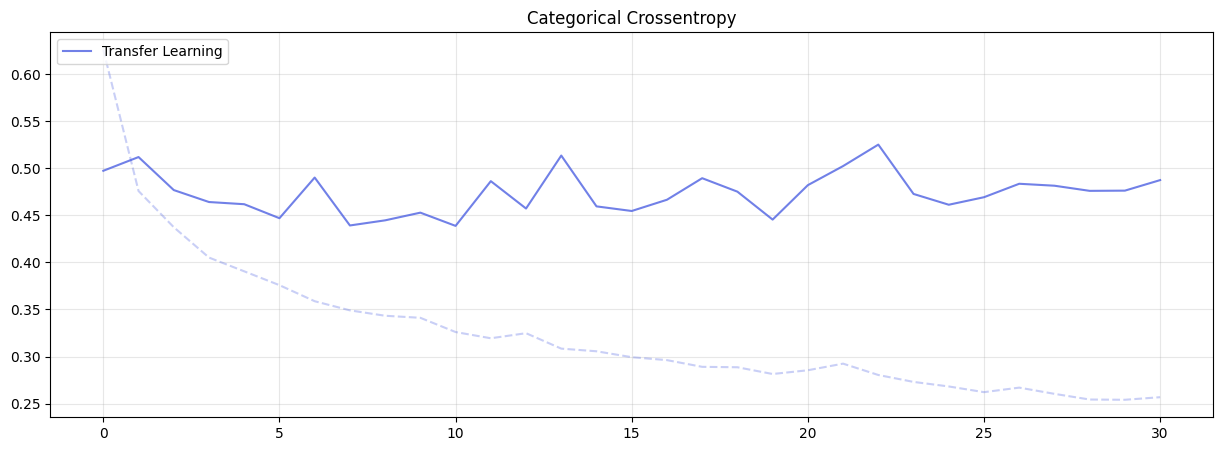

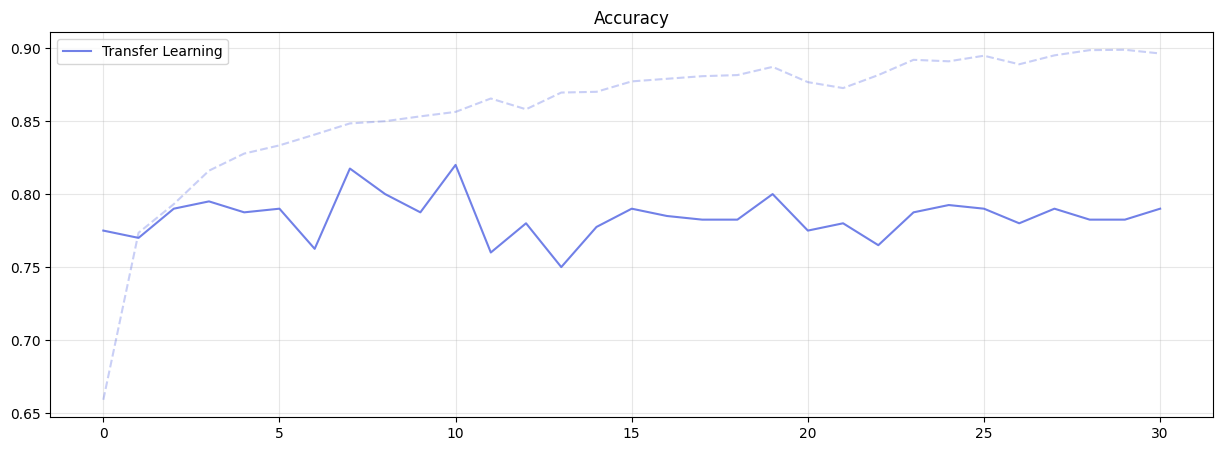

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
tl_model.save('MobileNetV2-TranferLearning')
del tl_model

####MobileNetV2-Fine Tuning

In [ ]:
#without reloading
ft_model=tl_model

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('MobileNetV2-TranferLearning')
ft_model.summary()

In [ ]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [ ]:
# Freeze first N layers, e.g., until the 120rd one
N = 120
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
# Compile the model with lower learning rate
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input_MobileNetV2(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (preprocess_input_MobileNetV2(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
62/62 [==============================] - 12s 65ms/step - loss: 0.6671 - accuracy: 0.7047 - val_loss: 0.4586 - val_accuracy: 0.8050
Epoch 2/200
62/62 [==============================] - 2s 37ms/step - loss: 0.4886 - accuracy: 0.7814 - val_loss: 0.4627 - val_accuracy: 0.8025
Epoch 3/200
62/62 [==============================] - 2s 37ms/step - loss: 0.4203 - accuracy: 0.8120 - val_loss: 0.4634 - val_accuracy: 0.8025
Epoch 4/200
62/62 [==============================] - 2s 36ms/step - loss: 0.3471 - accuracy: 0.8436 - val_loss: 0.4599 - val_accuracy: 0.8000
Epoch 5/200
62/62 [==============================] - 2s 38ms/step - loss: 0.2969 - accuracy: 0.8744 - val_loss: 0.4606 - val_accuracy: 0.8100
Epoch 6/200
62/62 [==============================] - 3s 44ms/step - loss: 0.2612 - accuracy: 0.8935 - val_loss: 0.4593 - val_accuracy: 0.8175
Epoch 7/200
62/62 [==============================] - 3s 44ms/step - loss: 0.2291 - accuracy: 0.9045 - val_loss: 0.4575 - val_accuracy: 0.8225
Epoch

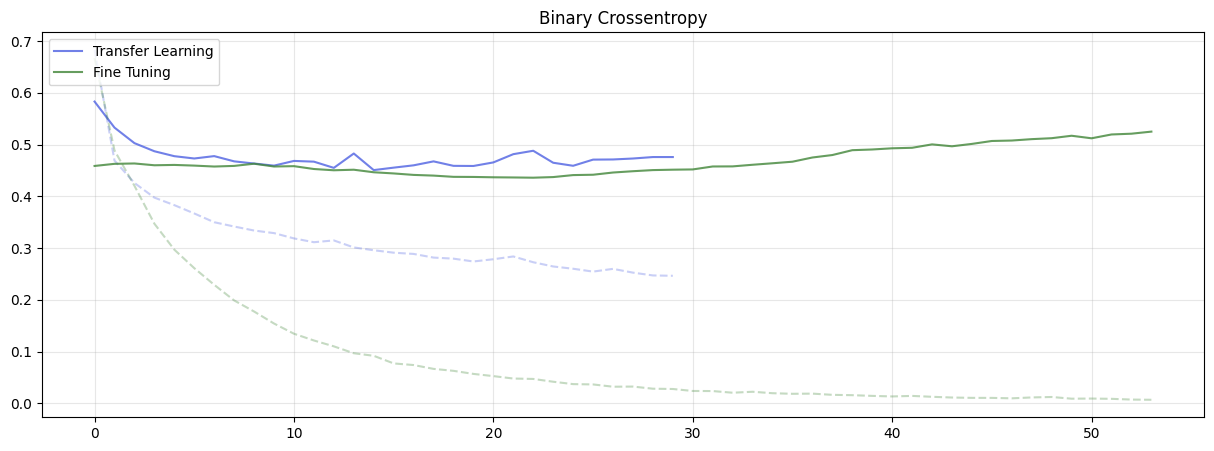

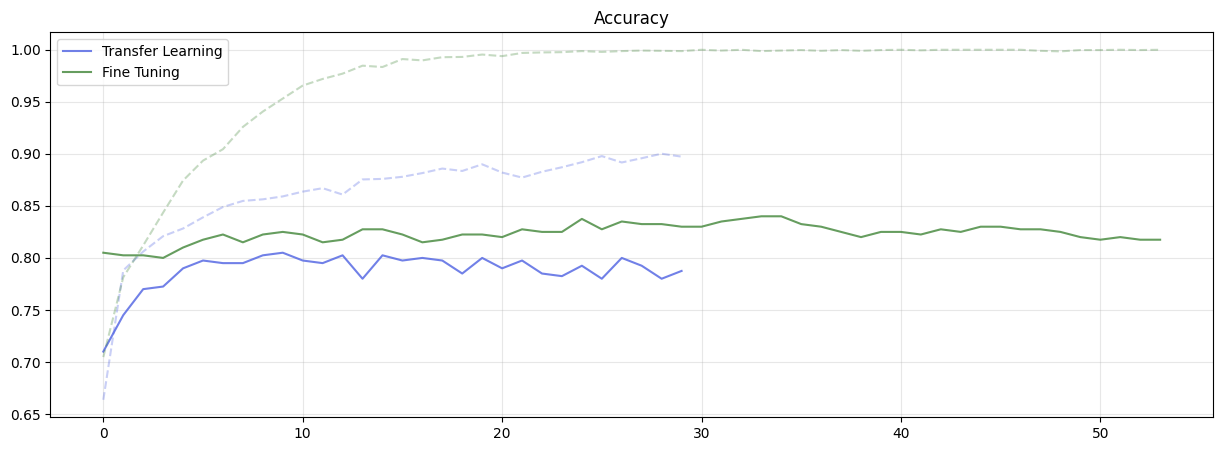

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
tl_model.save('MobileNetV2-FineTuning')
del tl_model

####EfficientNetB6/7-Tranfer Learning


In [ ]:
#import library
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_EfficientNet

Select here if you want to use B6 or B7

In [ ]:
efficientB7 = tfk.applications.efficientnet.EfficientNetB7(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(efficientB7, show_shapes=True)


In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
efficientB7.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))
# Connect EfficientNetB6 to the input
x = efficientB7(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input_EfficientNet(X_train*255), # We need to apply the preprocessing thought for the EfficientNet network
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (preprocess_input_EfficientNet(X_val*255), y_val), # We need to apply the preprocessing thought for the EfficientNet network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
tl_model.save('EfficientNet-TranferLearning')
del tl_model

####EfficientNetB6/7-Fine Tuning

In [ ]:
#if you don t delete tl_model
ft_model = tl_model

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('EfficientNet-TranferLearning')
ft_model.summary()

In [ ]:
# Set all EfficientNetB6 layers as trainable
ft_model.get_layer('efficientnetb6').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetb6').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers, e.g., until the 500rd one
N = 500
for i, layer in enumerate(ft_model.get_layer('efficientnetb6').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetb6').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model with lower learning rate
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input_EfficientNet(X_train*255), # We need to apply the preprocessing thought for the EfficientNet network
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (preprocess_input_EfficientNet(X_val*255), y_val), # We need to apply the preprocessing thought for the EfficientNet network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned EfficientNet training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
ft_model.save('EfficientNet-FineTuning')

In [ ]:
#delete if you want
del ft_model

####ConvNeXt: Base and Large -Transfer Learning

In [ ]:
#import library
from tensorflow.keras.applications.convnext import preprocess_input as preprocess_input_ConvNeXt

In [ ]:
#already imported library at beginnning of the file
convnext = tfk.applications.ConvNeXtLarge( #ConvNeXtBase
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(convnext, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
batch_size = 64
epochs = 200

In [ ]:
# Define ModelCheckpoint callback
checkpoint_path = "“training1_ckpt/cp.ckpt”"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, monitor='val_accuracy', verbose=1, save_weights_only=True,
   # Save weights, only best.
   save_freq=30*(int(len(X_train)/batch_size)),mode='max',save_best_only=False) #4:number of epochs

In [ ]:
#Early Stopping
es = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='auto')

In [ ]:
del tl_model

In our final model we've used only 1 output Dense layer with 2 neuron

In [ ]:
convnext.trainable = False

inputs = tfk.Input(shape=(96, 96, 3))
transform = transformation(inputs)

x = convnext(transform)
#x =tf.keras.layers.Dropout(0.3)(x)

#x =tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(1e-3), kernel_initializer=tfk.initializers.HeUniform(seed))(x)
#x =tf.keras.layers.Dropout(0.3)(x)

outputs = tfkl.Dense(units=2, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed),name='Output')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 1024)              1573888   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                             

In [ ]:
# Train the Tranfer Learning model
tl_history = tl_model.fit(
    x = preprocess_input_ConvNeXt(X_train*255), # We need to apply the preprocessing thought for the ConvNeXt network
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input_ConvNeXt(X_val*255), y_val), # We need to apply the preprocessing thought for the ConvNeXt network
    callbacks = [checkpoint_callback,es],
    #class_weight = class_weights
).history

Epoch 1/200
59/59 [==============================] - 75s 729ms/step - loss: 47.3437 - accuracy: 0.6644 - val_loss: 24.8243 - val_accuracy: 0.7940
Epoch 2/200
59/59 [==============================] - 26s 441ms/step - loss: 14.9062 - accuracy: 0.7946 - val_loss: 8.3402 - val_accuracy: 0.7780
Epoch 3/200
59/59 [==============================] - 28s 474ms/step - loss: 5.8572 - accuracy: 0.7766 - val_loss: 4.0323 - val_accuracy: 0.7620
Epoch 4/200
59/59 [==============================] - 29s 488ms/step - loss: 3.1430 - accuracy: 0.7957 - val_loss: 2.4034 - val_accuracy: 0.8440
Epoch 5/200
59/59 [==============================] - 28s 477ms/step - loss: 2.0475 - accuracy: 0.8121 - val_loss: 1.7056 - val_accuracy: 0.8440
Epoch 6/200
59/59 [==============================] - 27s 454ms/step - loss: 1.5328 - accuracy: 0.8188 - val_loss: 1.2339 - val_accuracy: 0.8740
Epoch 7/200
59/59 [==============================] - 26s 437ms/step - loss: 1.2095 - accuracy: 0.8298 - val_loss: 1.1318 - val_accura

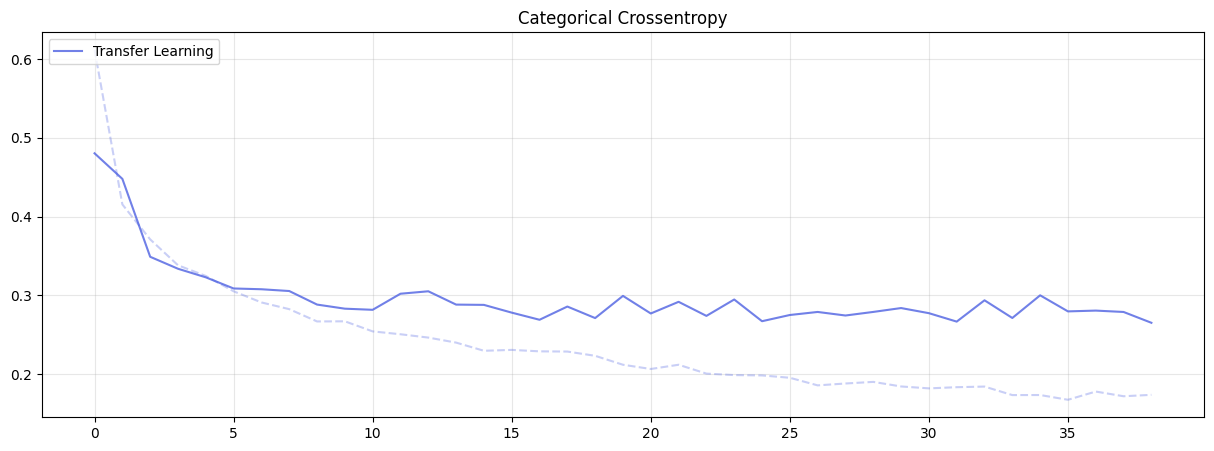

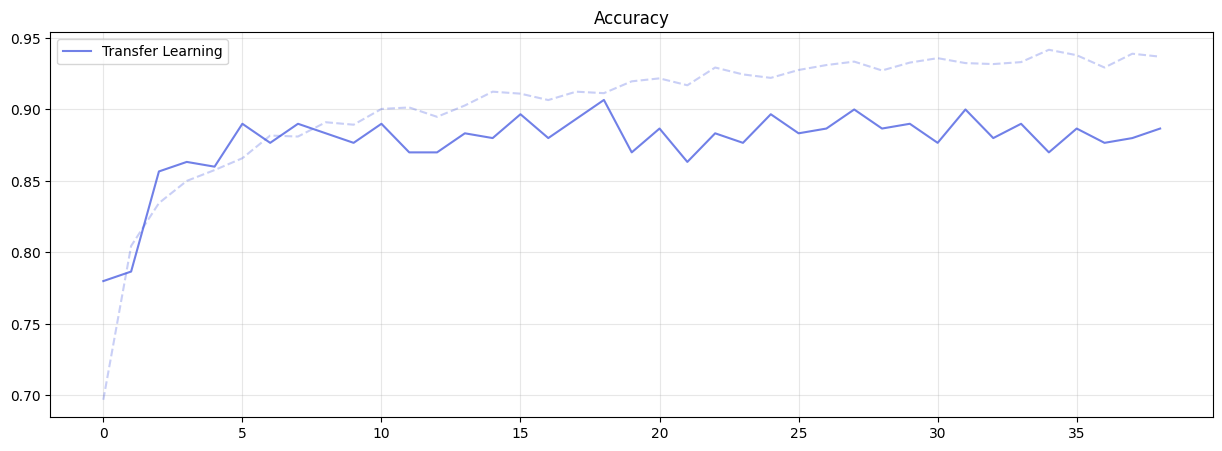

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
tl_model.save('ConvNeXt-TranferLearning')
#del tl_model

In [ ]:
# Evaluate the model on the val set
test_accuracy = tl_model.evaluate((X_val*255),y_val,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.9067


####ConvNeXt: Baseand Large -Fine Tuning

In [ ]:
#if you don t delete tl_model
ft_model = tl_model

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('ConvNeXt-TranferLearning')
ft_model.summary()

In [ ]:
# Set all ConvNeXt layers as trainable
ft_model.get_layer('convnext_large').trainable = True
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)

0 input_4 True
1 convnext_large_prestem_normalization True
2 convnext_large_stem True
3 convnext_large_stage_0_block_0_depthwise_conv True
4 convnext_large_stage_0_block_0_layernorm True
5 convnext_large_stage_0_block_0_pointwise_conv_1 True
6 convnext_large_stage_0_block_0_gelu True
7 convnext_large_stage_0_block_0_pointwise_conv_2 True
8 convnext_large_stage_0_block_0_layer_scale True
9 convnext_large_stage_0_block_0_identity True
10 tf.__operators__.add_36 True
11 convnext_large_stage_0_block_1_depthwise_conv True
12 convnext_large_stage_0_block_1_layernorm True
13 convnext_large_stage_0_block_1_pointwise_conv_1 True
14 convnext_large_stage_0_block_1_gelu True
15 convnext_large_stage_0_block_1_pointwise_conv_2 True
16 convnext_large_stage_0_block_1_layer_scale True
17 convnext_large_stage_0_block_1_identity True
18 tf.__operators__.add_37 True
19 convnext_large_stage_0_block_2_depthwise_conv True
20 convnext_large_stage_0_block_2_layernorm True
21 convnext_large_stage_0_block_2_poin

In [ ]:
# Freeze first N layers, e.g., until the 250rd one
N = 250
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_4 False
1 convnext_large_prestem_normalization False
2 convnext_large_stem False
3 convnext_large_stage_0_block_0_depthwise_conv False
4 convnext_large_stage_0_block_0_layernorm False
5 convnext_large_stage_0_block_0_pointwise_conv_1 False
6 convnext_large_stage_0_block_0_gelu False
7 convnext_large_stage_0_block_0_pointwise_conv_2 False
8 convnext_large_stage_0_block_0_layer_scale False
9 convnext_large_stage_0_block_0_identity False
10 tf.__operators__.add_36 False
11 convnext_large_stage_0_block_1_depthwise_conv False
12 convnext_large_stage_0_block_1_layernorm False
13 convnext_large_stage_0_block_1_pointwise_conv_1 False
14 convnext_large_stage_0_block_1_gelu False
15 convnext_large_stage_0_block_1_pointwise_conv_2 False
16 convnext_large_stage_0_block_1_layer_scale False
17 convnext_large_stage_0_block_1_identity False
18 tf.__operators__.add_37 False
19 convnext_large_stage_0_block_2_depthwise_conv False
20 convnext_large_stage_0_block_2_layernorm False
21 convnext_large

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input_ConvNeXt(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input_ConvNeXt(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [checkpoint_callback,es],
    #class_weight = class_weights
).history

Epoch 1/200
59/59 [==============================] - 117s 1s/step - loss: 0.4754 - accuracy: 0.8862 - val_loss: 0.4389 - val_accuracy: 0.8800
Epoch 2/200
59/59 [==============================] - 53s 901ms/step - loss: 0.3682 - accuracy: 0.9173 - val_loss: 0.4246 - val_accuracy: 0.8780
Epoch 3/200
59/59 [==============================] - 53s 895ms/step - loss: 0.3165 - accuracy: 0.9474 - val_loss: 0.4166 - val_accuracy: 0.8940
Epoch 4/200
59/59 [==============================] - 55s 929ms/step - loss: 0.2853 - accuracy: 0.9560 - val_loss: 0.4168 - val_accuracy: 0.8880
Epoch 5/200
59/59 [==============================] - 55s 926ms/step - loss: 0.2477 - accuracy: 0.9694 - val_loss: 0.4333 - val_accuracy: 0.8940
Epoch 6/200
59/59 [==============================] - 55s 939ms/step - loss: 0.2271 - accuracy: 0.9809 - val_loss: 0.4403 - val_accuracy: 0.9000
Epoch 7/200
59/59 [==============================] - 53s 900ms/step - loss: 0.2144 - accuracy: 0.9855 - val_loss: 0.4361 - val_accuracy: 0

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned EfficientNetB6 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')       ##### I THINK IT S CATEGORICAL CROSS ENTROPY
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
ft_model.save('ConvNeXtBase-FineTuning')

In [ ]:
import tensorflow.keras.backend as K


In [ ]:
# Evaluate the model on the val set
test_accuracy = ft_model.evaluate((X_val*255),y_val,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.9140


In [ ]:
ft_model.save('ConvNeXtBase-FineTuning')


In [ ]:
# Load checkpoint:
#if checkpoint_path is not None:
#    # Load model:
#    model = tfk.models.load_model(checkpoint_path)
#    # Learning rate used
#    print(K.get_value(model.optimizer.lr))



### Make inference

In [ ]:
# load the model
#model_to_test = tfk.models.load_model('EfficientNetB6-TranferLearning')
model_to_test = tfk.models.load_model('ConvNeXtBase-FineTuning')

In [ ]:
#if no load
model_to_test=ft_model

In [ ]:
# Predict labels for the entire test set
predictions = model_to_test.predict(X_test*255, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (200, 2)


Accuracy: 0.9
Precision: 0.9028
Recall: 0.8996
F1: 0.8997


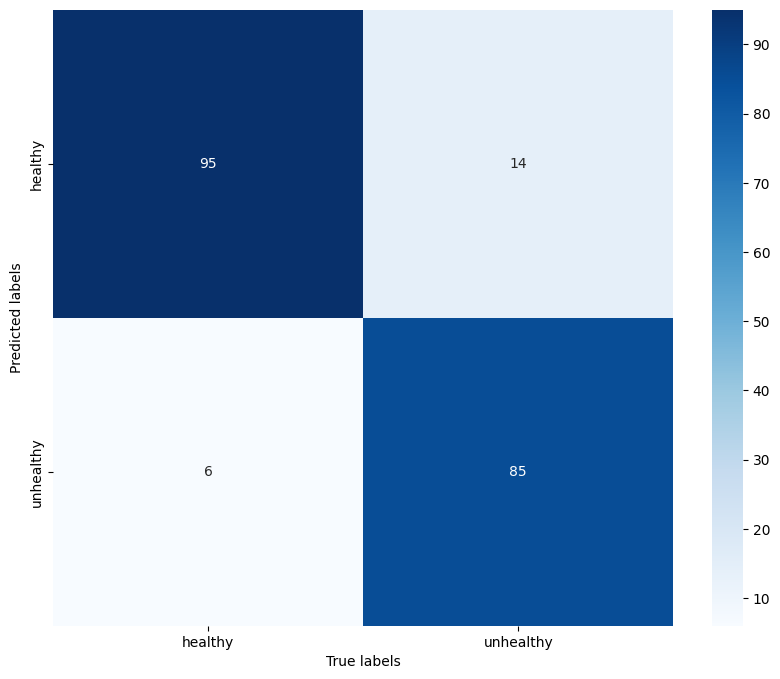

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True, fmt='d')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

###Test Time Augmentation

In augment_image(image) function you can change the parameters of the augmentations that you want.
This configuration helped to increase the accuracy of the EffecientNetB7 from 83% to 88% in the competition testset.

**This code has to be included in the model.py file if you want to perform test time augmentation.**

In [ ]:
model = tfk.models.load_model('ConvNeXtBase-FineTuning')

In [ ]:
import cv2
def rotate_image(image, angle): #and flip
    image = cv2.flip(image, 1)
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    return rotated_image

def translate_image(image, tx, ty): #and flip
    image = cv2.flip(image, 0)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return translated_image

def zoom_image(image, factor):
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 0, factor)
    zoomed_image = cv2.warpAffine(image, M, (cols, rows))
    return zoomed_image

def flip_image(image, flip_horizontal=False, flip_vertical=False):
    if flip_horizontal:
        image = cv2.flip(image, 1)
    if flip_vertical:
        image = cv2.flip(image, 0)
    return image

def augment_image(image):
    #Select the parameters of yours augmentations
    rotated_image = rotate_image(image, 2)
    translated_image = translate_image(image, 2, 2)
    zoomed_image = zoom_image(image, 1.1)
    flipped_image1 = flip_image(image, flip_horizontal=True, flip_vertical=False)
    flipped_rotate = rotate_image(flip_image(image, flip_horizontal=False, flip_vertical=True), -3)

    return image, rotated_image, translated_image, zoomed_image, flipped_image1, flipped_rotate


def plot_images(images, titles):
    num_images = len(images)
    rows = 1
    cols = num_images

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3))

    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.show()

In [ ]:
def predict_tta(images): #note: it returns predictions like model.predic -> [prob Class1, probClass2]
  predictions_aggregate = []
  for img in images:
    aug_images = np.array(augment_image(img))
    predictions = model_to_test.predict(aug_images, verbose=0)
    pred_agg = np.mean(predictions, axis=0)
    #pred = np.argmax(pred_agg, axis=1)
    predictions_aggregate.append(pred_agg)
  return np.array(predictions_aggregate)

In [ ]:
# Predict labels for the entire test set [TEST TIME AUGMENTATION]
tta_predictions = predict_tta(X_test*255)
tta_predictions.shape

(200, 2)

Accuracy: 0.9
Precision: 0.9001
Recall: 0.9001
F1: 0.9


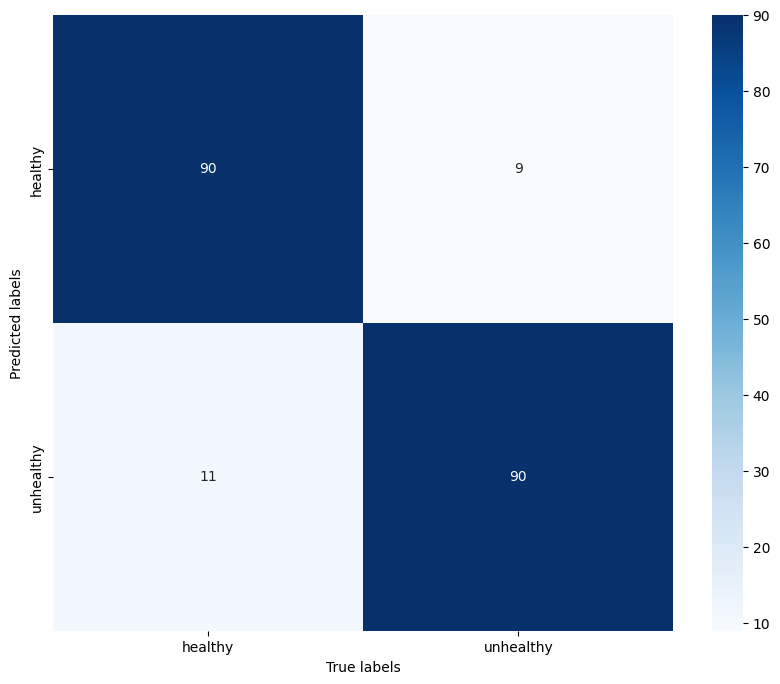

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(tta_predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(tta_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(tta_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(tta_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(tta_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True, fmt='d')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

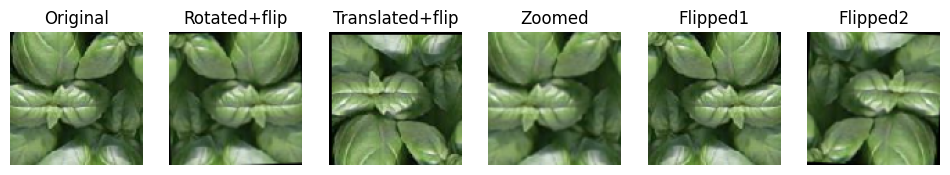

In [ ]:
#just to show the augmentations.
original_image = images[3]
image,rotated_image, translated_image, zoomed_image, flipped_image1, flipped_image2 = augment_image(original_image)
res_images = [image, rotated_image, translated_image, zoomed_image, flipped_image1, flipped_image2]
titles = ['Original', 'Rotated+flip', 'Translated+flip', 'Zoomed', 'Flipped1', 'Flipped2']

plot_images(res_images, titles)


# CAM

In [ ]:
#load test set
import scipy
X_test_preprocessed = preprocess_input(X_test*255)

In [ ]:
#load models
enb7_model = tf.keras.models.load_model('EfficientNetB7-FineTuning')
conv_model = tf.keras.models.load_model('Convnextbase')

In [ ]:
def compute_enb7_CAM(model, img):
    # Expand image dimensions to fit the model input shape
    img = np.expand_dims(img, axis=0)

    # Predict to get the winning class
    predictions = model.predict(img, verbose=0)
    label_index = np.argmax(predictions)

    # Get the 1028 input weights to the softmax of the winning class
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]

    # Define the final convolutional layer of the EfficientNetb7 model
    final_conv_layer = tfk.Model(
        model.get_layer('efficientnetb7').input,
        model.get_layer('efficientnetb7').get_layer('top_conv').output
    )

    # Compute the convolutional outputs and squeeze the dimensions
    conv_outputs = final_conv_layer(img)
    conv_outputs = np.squeeze(conv_outputs)

    # Upsample the convolutional outputs and compute the final output using the class weights
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1)
    final_output = np.dot(mat_for_mult.reshape((96*96, 2560)), class_weights_winner).reshape(96, 96)

    return final_output, label_index, predictions

In [ ]:
def compute_conv_CAM(model, img):
    # Expand image dimensions to fit the model input shape
    img = np.expand_dims(img, axis=0)

    # Predict to get the winning class
    predictions = model.predict(img, verbose=0)
    label_index = np.argmax(predictions)

    # Get the 1028 input weights to the softmax of the winning class
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]

    # Define the final convolutional layer of the Convnext model
    final_conv_layer = tfk.Model(
        model.get_layer('convnext_base').input,
        model.get_layer('convnext_base').get_layer('convnext_base_stage_3_block_2_layer_scale').output
    )

    # Compute the convolutional outputs and squeeze the dimensions
    conv_outputs = final_conv_layer(img)
    conv_outputs = np.squeeze(conv_outputs)

    # Upsample the convolutional outputs and compute the final output using the class weights
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1)
    final_output = np.dot(mat_for_mult.reshape((96*96, 1024)), class_weights_winner).reshape(96, 96)

    return final_output, label_index, predictions

In [ ]:
# Make a list of the CAM output
enb7_values = []
conv_values = []
for img in X_test_preprocessed:
    enb7_values.append(compute_enb7_CAM(enb7_model, img))
    conv_values.append(compute_conv_CAM(conv_model, img))
enb7_values = np.array(enb7_values)
conv_values = np.array(conv_values)

In [ ]:
# change numbers to string labels for the plot
num_to_labels = {0: 'h', 1: 'uh'}

In [ ]:
# Save the data
num_img = 60

#For the enb7 model
for i in range(num_img):
    confidence = round(enb7_values[i][2][0][enb7_values[i][1]] * 100,1)
    plt.imshow(enb7_values[i][0], cmap='turbo')
    plt.imshow(np.clip(X_test[i], 0, 255), alpha=0.5)
    plt.axis('off')
    label = num_to_labels[enb7_values[i][1]]
    plt.title('{}: {}% ({})'.format(label, confidence, num_to_labels[y_test[i][1]]), fontsize = 30)
    plt.savefig('ENB7_CAM/Test{0}.jpg'.format(i))
    plt.tight_layout()
    plt.show()

#For the ConvNeXt model
for i in range(num_img):
    confidence = round(conv_values[i][2][0][conv_values[i][1]] * 100,1)
    plt.imshow(conv_values[i][0], cmap='turbo')
    plt.imshow(np.clip(X_test[i], 0, 255), alpha=0.5)
    plt.axis('off')
    label = num_to_labels[conv_values[i][1]]
    plt.title('{}: {}% ({})'.format(label, confidence, num_to_labels[y_test[i][1]]), fontsize = 30)
    plt.savefig('Convnext_CAM/Test{0}.jpg'.format(i))
    plt.tight_layout()
    plt.show()